# **[HW5] Language Model**
1. DataLoader
2. Model
3. Trainer
4. Generation

이번 실습에서는 RNN기반의 Language Model를 구현해서 텍스트를 직접 생성해보는 실습을 진행해보겠습니다.

- dataset: WikiText2 (https://github.com/pytorch/examples/tree/master/word_language_model/data/wikitext-2)
- model: LSTM




## Import packages

런타임의 유형을 변경해줍니다.

상단 메뉴에서 [런타임]->[런타임유형변경]->[하드웨어가속기]->[GPU]

변경 이후 아래의 cell을 실행 시켰을 때, torch.cuda.is_avialable()이 True가 나와야 합니다.



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())

1.10.0+cu111
True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tqdm
import os
import random
import time
import datetime

# for reproducibility
random.seed(1234)
np.random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 1. DataLoader

이전의 실습들에서 사용한것과 마찬가지로, PyTorch style의 dataloader를 먼저 만들어 두겠습니다.

### Dataset

저희가 이번 실습에서 사용할 데이터셋은 Wikipedia에 있는 영문 글들을 가져온 WikiTree dataset입니다.
저희가 불러올 데이터는 가장 작은 WikiTree dataset에서 자주 사용되지 않는 단어나 영어가 아닌 단어들은 unknown token ([unk]) 으로 이미 전처리가 되어있습니다.

In [3]:
import urllib
with urllib.request.urlopen('https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/02-intermediate/language_model/data/train.txt') as f:
    data = f.readlines()

In [4]:
print('num_sentence:',len(data))
data[100]

num_sentence: 42068


b" plans that give advertisers discounts for maintaining or increasing ad spending have become permanent <unk> at the news <unk> and underscore the fierce competition between newsweek time warner inc. 's time magazine and <unk> b. <unk> 's u.s. news & world report \n"

In [5]:
data[100].split()

[b'plans',
 b'that',
 b'give',
 b'advertisers',
 b'discounts',
 b'for',
 b'maintaining',
 b'or',
 b'increasing',
 b'ad',
 b'spending',
 b'have',
 b'become',
 b'permanent',
 b'<unk>',
 b'at',
 b'the',
 b'news',
 b'<unk>',
 b'and',
 b'underscore',
 b'the',
 b'fierce',
 b'competition',
 b'between',
 b'newsweek',
 b'time',
 b'warner',
 b'inc.',
 b"'s",
 b'time',
 b'magazine',
 b'and',
 b'<unk>',
 b'b.',
 b'<unk>',
 b"'s",
 b'u.s.',
 b'news',
 b'&',
 b'world',
 b'report']

In [6]:
# "나는 밥을 먹는다."
kor_data = "나는 밥을 먹는다."
kor_data.split()

['나는', '밥을', '먹는다.']

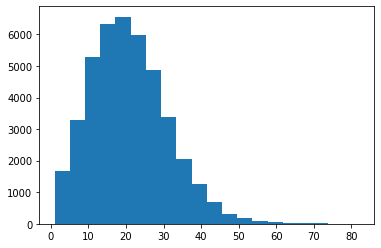

In [7]:
seq_length_list = []
for line in data:
    seq_length_list.append(len(line.split()))

counts, bins = np.histogram(seq_length_list, bins=20)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

데이터에 있는 문장 길이들의 histogram을 볼 때 대부분의 data의 문장 길이가 50에 미치지 못하기 때문에 \\
model에 집어넣을 최대 문장 길이를 50으로 세팅해두도록 하겠습니다.

In [8]:
max_seq_len = 50

### Build Dictionary

먼저 text 데이터를 모델에 넣어주기 위해서는 text에 존재하는 단어들을 index로 변환해주어야 합니다.

이를 위해서는 단어를 index로 변환해주는 word2idx dictionary와 다시 index를 단어로 변환해주는 idx2word dictionary를 만들어야 합니다.


In [9]:
def build_dictionary(data, max_seq_len):
    word2idx = {}
    idx2word = {}
    ## Build Dictionary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word[0] = '<pad>'
    idx2word[1] = '<unk>'
    idx = 2
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]        
        ### Build Dictionary to convert word to index and index to word
        ### YOUR CODE HERE (~ 5 lines)
        for word in words:
            if word not in word2idx:
                word2idx[word] = idx
                idx2word[idx] = word
                idx += 1

    return word2idx, idx2word

word2idx, idx2word = build_dictionary(data, max_seq_len)

In [10]:
if len(word2idx) == len(idx2word) == 10000:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


### Preprocessing

이제 앞서 만든 dictionary를 이용해서 text로된 데이터셋을 index들로 변환시키겠습니다.

In [11]:
def preprocess(data, word2idx, idx2word, max_seq_len):
    tokens = []
    for line in data:
        words = line.decode('utf-8').split()
        words = words[:max_seq_len]
        ### Convert dataset with tokens
        ### For each line, append <pad> token to match the number of max_seq_len
        ### YOUR CODE HERE (~ 4 lines)
        words += ['<pad>']*(max_seq_len - len(words))
        for word in words:
            token = word2idx[word]
            tokens.append(token)

    return tokens

tokens = preprocess(data, word2idx, idx2word, max_seq_len)

In [12]:
if len(tokens) == 2103400:
    print("Test Passed!")
else:
    raise AssertionError

Test Passed!


이제 전처리된 Token들을 문장 단위의 배열로 변환시켜 두겠습니다.

In [13]:
tokens = np.array(tokens).reshape(-1, max_seq_len)
print(tokens.shape)
tokens[100]

(42068, 50)


array([745,  93, 746, 739, 747, 181, 748, 467, 749, 740, 750, 154, 751,
       752,   1, 160,  32, 753,   1,  48, 754,  32, 755, 756, 757, 728,
       555, 758,  99, 119, 555, 733,  48,   1, 759,   1, 119, 237, 753,
       230, 760, 347,   0,   0,   0,   0,   0,   0,   0,   0])

### DataLoader

이제 전처리된 dataset을 활용하여 PyTorch style의 dataset과 dataloader를 만들도록 하겠습니다.

Token형태의 데이터를 PyTorch 스타일의 dataset으로 만들 때 주의할 점은, 추후 embedding matrix에서 indexing을 해주기 위해서 각 token이 LongTensor 형태로 정의되어야 한다는 점입니다.

In [14]:
class LMDataset(torch.utils.data.Dataset):
    def __init__(self, tokens):
        super(LMDataset, self).__init__()
        self.PAD = 0
        self.UNK = 1
        self.tokens = tokens
        self._getitem(2)

    def _getitem(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).unsqueeze(0).long()
        y = torch.from_numpy(y).unsqueeze(0).long()

        return X, y

    def __getitem__(self, index):
        X = self.tokens[index]
        y = np.concatenate((X[1:], [self.PAD]))

        X = torch.from_numpy(X).long()
        y = torch.from_numpy(y).long()

        return X, y

    def __len__(self):
        return len(self.tokens)

In [15]:
batch_size = 64
dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(len(dataset))
print(len(dataloader))

42068
658


# 2. Model

이번 section에서는 Language Modeling을 위한 Recurrent Model을 직접 만들어보도록 하겠습니다.

Standard한 Recurrent Neural Network (RNN) model은 vanishing gradient 문제에 취약하기 때문에, 이번 실습에서는 변형된 RNN구조인 LSTM model을 활용하도록 하겠습니다.


### LSTM

LSTM model의 전체적인 구조와 각 gate의 수식은 아래와 같습니다.

![](https://drive.google.com/uc?export=view&id=1n93tpNW55Xl4GxZNcJcbUVRhuNCGH38h)

![](https://drive.google.com/uc?export=view&id=1nH9U5iD9cO6OVVTbrx-LjypRvcWzbOCU)

LSTM의 자세한 동작방식이 궁금하신 분은 아래의 블로그를 참조해주세요.

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [16]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        # input-gate
        self.Wi = nn.Linear(input_size + hidden_size, hidden_size)
        # forget-gate
        self.Wf = nn.Linear(input_size + hidden_size, hidden_size)
        # gate-gate
        self.Wg = nn.Linear(input_size + hidden_size, hidden_size)
        # output-gate
        self.Wo = nn.Linear(input_size + hidden_size, hidden_size)

        # non-linearity
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h_0, c_0):
        """
        Inputs
            input (x): [batch_size, input_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
        Outputs
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        h_1, c_1 = None, None
        input = torch.cat((x, h_0), 1)
        # Implement LSTM cell as noted above
        ### YOUR CODE HERE (~ 6 lines)
        i = self.sigmoid(self.Wi(input))
        f = self.sigmoid(self.Wf(input))
        g = self.tanh(self.Wg(input))
        o = self.sigmoid(self.Wo(input))
        c_1 = f * c_0 + i * g
        h_1 = o * self.tanh(c_1)

        return h_1, c_1

In [17]:
def test_lstm():
    batch_size = 2
    input_size = 5
    hidden_size = 3

    #torch.manual_seed(1234)
    lstm = LSTMCell(input_size ,hidden_size)
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.constant_(m.weight, 0.1)
            m.bias.data.fill_(0.01)
    lstm.apply(init_weights)

    x = torch.ones(batch_size, input_size)
    hx = torch.zeros(batch_size, hidden_size)
    cx = torch.zeros(batch_size, hidden_size)

    hx, cx = lstm(x, hx, cx)
    assert hx.detach().allclose(torch.tensor([[0.1784, 0.1784, 0.1784], 
                                              [0.1784, 0.1784, 0.1784]]), atol=2e-1), \
            f"Output of the hidden state does not match."
    assert cx.detach().allclose(torch.tensor([[0.2936, 0.2936, 0.2936], 
                                              [0.2936, 0.2936, 0.2936]]), atol=2e-1), \
            f"Output of the cell state does not match."

    print("==LSTM cell test passed!==")

test_lstm()

==LSTM cell test passed!==


## Language Model

이제, 위에서 정의한 LSTM Cell을 활용해서 아래와 같은 Langauge Model을 만들어보도록 하겠습니다.


![](https://drive.google.com/uc?export=view&id=1nMAbL-g31nERM44dgohA3k9Vj_92hIh-)

In [18]:
class LanguageModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=64, vocab_size=10000):
        super(LanguageModel, self).__init__()
        
        self.input_layer = nn.Embedding(vocab_size, input_size)
        self.hidden_layer = LSTMCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, vocab_size)


    def forward(self, x, hx, cx, predict=False):
        """
        Inputs
            input (x): [batch_size]
            hidden_state (h_0): [batch_size, hidden_size]
            cell_state (c_0): [batch_size, hidden_size]
            predict: whether to predict and sample the next word
        Outputs
            output (ox): [batch_size, hidden_size]
            next_hidden_state (h_1): [batch_size, hidden_size]
            next_cell_state (c_1): [batch_size, hidden_size]    
        """
        x = self.input_layer(x)
        hx, cx = self.hidden_layer(x, hx, cx)
        ox = self.output_layer(hx)

        if predict == True:
            probs = F.softmax(ox, dim=1)
            # torch distribution allows sampling operation
            # see https://pytorch.org/docs/stable/distributions.html
            dist = torch.distributions.Categorical(probs)
            ox = dist.sample()

        return ox, hx, cx  

# 3. Trainer

자 이제 위에서 구현한 dataloader와 langauge model을 활용해서 모델의 학습을 진행해보도록 하겠습니다.


In [19]:
class Trainer():
    def __init__(self, 
                 word2idx, 
                 idx2word,
                 dataloader, 
                 model, 
                 criterion,
                 optimizer, 
                 device):
        """
        dataloader: dataloader
        model: langauge model
        criterion: loss function to evaluate the model (e.g., BCE Loss)
        optimizer: optimizer for model
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.dataloader = dataloader
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        
    def train(self, epochs = 1):
        self.model.to(self.device)
        start_time = time.time()
        for epoch in range(epochs):
            losses = []
            for iter, (x_batch, y_batch) in tqdm.tqdm(enumerate(self.dataloader)):
                self.model.train()
                
                batch_size, max_seq_len = x_batch.shape
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # initial hidden-states
                hx = torch.zeros(batch_size, hidden_size).to(self.device)
                cx = torch.zeros(batch_size, hidden_size).to(self.device)

                # Implement LSTM operation
                ox_batch = []
                # Get output logits for each time sequence and append to the list, ox_batch
                # YOUR CODE HERE (~ 4 lines)
                for s_idx in range(max_seq_len):
                    x = x_batch[:, s_idx]
                    ox, hx, cx = self.model(x, hx, cx)
                    ox_batch.append(ox)
                # outputs are ordered by the time sequence
                ox_batch = torch.cat(ox_batch).reshape(max_seq_len, batch_size, -1)
                ox_batch = ox_batch.permute(1,0,2).reshape(batch_size*max_seq_len, -1)
                y_batch = y_batch.reshape(-1)

                self.model.zero_grad()
                loss = self.criterion(ox_batch, y_batch)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())

            end_time = time.time() - start_time
            end_time = str(datetime.timedelta(seconds=end_time))[:-7]
            print('Time [%s], Epoch [%d/%d], loss: %.4f'
                  % (end_time, epoch+1, epochs, np.mean(losses)))
            if epoch % 5 == 0:
                generated_sentences = self.test()
                print('[Generated Sentences]')
                for sentence in generated_sentences:
                    print(sentence)
            
    def test(self):
        # Test model to genereate the sentences
        self.model.eval()
        num_sentence = 5
        max_seq_len = 50

        # initial hidden-states
        outs = []
        x = torch.randint(0, 10000, (num_sentence,)).to(self.device)
        hx = torch.zeros(num_sentence, hidden_size).to(self.device)
        cx = torch.zeros(num_sentence, hidden_size).to(self.device)

        outs.append(x)
        with torch.no_grad():
            for s_idx in range(max_seq_len-1):
                x, hx, cx = self.model(x, hx, cx, predict=True)
                outs.append(x)
        outs = torch.cat(outs).reshape(max_seq_len, num_sentence)
        outs = outs.permute(1, 0)
        outs = outs.detach().cpu().numpy()

        sentences = []
        for out in outs:
            sentence = []
            for token_idx in out:
                word = self.idx2word[token_idx]
                sentence.append(word)
            sentences.append(sentence)
       
        return sentences

In [20]:
lr = 1e-2
input_size = 128
hidden_size = 128
batch_size = 256

dataset = LMDataset(tokens)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = LanguageModel(input_size=input_size, hidden_size=hidden_size)
# NOTE: you should use ignore_index to ignore the loss from predicting the <PAD> token
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device('cuda')

trainer = Trainer(word2idx = word2idx,
                  idx2word = idx2word,
                  dataloader=dataloader, 
                  model = model,
                  criterion=criterion,
                  optimizer = optimizer,
                  device=device)

trainer.train(epochs=50)

165it [00:37,  4.36it/s]


Time [0:00:37], Epoch [1/50], loss: 6.0854
[Generated Sentences]
['incur', 'principle', 'purchase', 'will', 'go', 'about', 'N', 'cents', 'a', 'year', 'ago', 'thus', 'critics', 'were', 'often', 'remember', 'monday', 'circulating', 'at', 'N', 'to', '$', 'N', 'N', 'to', 'N', 'million', 'of', 'about', '$', 'N', 'billion', 'account', 'for', 'composite', 'trading', 'claims', 'because', 'the', 'clutter', 'of', 'trading', 'for', 'growth', 'manville', 'previously', 'said', 'the', 'growth', 'crash']
['arrange', 'catalog', 'securities', 'loan', 'union', 'of', 'the', 'same', 'tests', 'service', 'in', 'north', 'goal', 'of', 'the', 'relationships', 'between', 'innopac', 'war', 'and', 'drugs', 'it', 'requires', 'asking', 'operators', 'on', 'five', 'pence', 'initiated', 'of', 'industrial', 'budget', 'because', 'they', 'disclosed', 'it', 'semel', 'announced', 'setting', 'the', 'redemption', 'limit', 'in', 'ual', 'according', 'to', 'measure', 'led', 'and', 'concede']
['parliament', 'b.a.t', "'s", 'custo

165it [00:38,  4.33it/s]


Time [0:01:16], Epoch [2/50], loss: 5.2175


165it [00:37,  4.37it/s]


Time [0:01:53], Epoch [3/50], loss: 4.9052


165it [00:37,  4.37it/s]


Time [0:02:31], Epoch [4/50], loss: 4.6972


165it [00:37,  4.36it/s]


Time [0:03:09], Epoch [5/50], loss: 4.5410


165it [00:37,  4.37it/s]


Time [0:03:47], Epoch [6/50], loss: 4.4145
[Generated Sentences]
['computer-guided', 'merged', '&', 'co.', "'s", '<unk>', 'institution', 'while', 'nl', 'that', 'the', 'agency', 'that', 'said', 'it', 'is', 'some', 'of', 'employee', 'efforts', 'in', '<unk>', 'defense', 'most', 'costly', 'and', 'home', 'products', 'have', 'no', 'ideological', 'pool', 'policy', 'electoral', 'districts', 'for', 'its', 'paper', 'mill', 'that', 'would', 'allow', 'foreign', 'aid', 'to', '$', 'N', 'million', 'in', 'garbage']
['opportunities', 'caution', 'that', 'the', 'equivalent', 'of', 'four', 'others', 'are', 'certainly', 'as', 'the', 'engine', 'vote', 'for', 'individual', 'balls', 'plc', 'london', 'owner', '<unk>', 'in', 'august', 'he', 'expected', 'from', 'the', 'sale', 'of', 'its', 'interests', 'of', 'coin', 'wrap', '<unk>', 'credit', 'collection', 'great', 'britain', 'as', 'a', 'other', 'major', 'customer', 'natural', 'gas', 'tax', 'and', '<unk>', 'in']
['it', 'was', 'up', 'following', 'london', '<unk>',

165it [00:37,  4.37it/s]


Time [0:04:25], Epoch [7/50], loss: 4.3090


165it [00:37,  4.35it/s]


Time [0:05:03], Epoch [8/50], loss: 4.2152


165it [00:37,  4.36it/s]


Time [0:05:40], Epoch [9/50], loss: 4.1369


165it [00:37,  4.36it/s]


Time [0:06:18], Epoch [10/50], loss: 4.0667


165it [00:37,  4.35it/s]


Time [0:06:56], Epoch [11/50], loss: 4.0021
[Generated Sentences]
['beginning', 'these', 'show', 'featured', 'in', 'the', 'musical', 'soviet', 'border', 'firms', '<unk>', 'at', 'kate', 'research', 'in', 'the', 'world', 'that', 'gene', '<unk>', "'s", 'own', 'argument', 'is', 'complicated', 'to', 'the', 'president', 'of', '<unk>', 'though', 'no', '<unk>', 'of', 'N', 'N', 'and', 'N', 'N', 'blacks', 'actors', 'reached', 'an', 'ad', 'illustrates', 'the', 'defense', 'had', 'suggested', 'would']
['personal-injury', 'countries', 'would', 'represent', 'the', 'plane', 'crash', 'for', 'its', 'plants', 'human', 'services', 'in', 'central', 'planning', 'the', 'creation', 'of', 'the', 'proposed', 'agreement', 'is', 'making', 'any', 'of', 'its', 'loan', 'operating', 'within', 'N', 'shares', 'which', 'is', 'not', 'at', 'all', 'of', '<unk>', 'stock', 'investment', 'because', 'of', 'the', 'market', 'turned', 'out', 'of', 'the', 'british', 'banks']
['riding', 'picks', 'test', 'intraday', 'guilty', 'after

165it [00:37,  4.36it/s]


Time [0:07:34], Epoch [12/50], loss: 3.9481


165it [00:37,  4.36it/s]


Time [0:08:12], Epoch [13/50], loss: 3.8971


165it [00:37,  4.35it/s]


Time [0:08:50], Epoch [14/50], loss: 3.8497


165it [00:37,  4.36it/s]


Time [0:09:28], Epoch [15/50], loss: 3.8079


165it [00:37,  4.36it/s]


Time [0:10:06], Epoch [16/50], loss: 3.7714
[Generated Sentences]
['12-month', 'conspiracy', 'reasonable', 'owed', 'undervalued', 'experts', 'said', 'in', 'august', 'twice', 'and', 'ibm', "'s", '<unk>', 'of', '<unk>', 'ohio', 'had', 'to', 'be', 'because', 'from', 'previous', 'exports', 'to', '<unk>', 'a', 'customer', 'by', 'N', 'N', 'when', 'prices', 'seemed', 'to', 'focus', 'its', 'own', 'mildly', 'in', 'picking', 'up', 'and', 'minute', 'segments', 'in', '<unk>', 'on', 'fetal-tissue', 'transplants']
['work', 'on', 'the', 'major', 'professional', 'sense', 'for', 'mr.', '<unk>', 'who', 'participated', 'in', 'tampa', 'than', 'N', 'lawyers', 'assistant', 'to', 'materials', 'charges', 'that', 'the', 'agreement', 'is', 'in', 'marginal', 'negotiations', 'with', '<unk>', '<unk>', 'in', '<unk>', 'said', 'used', 'life', 'taken', 'in', 'price', 'when', 'the', 'supreme', 'court', 'ruling', 'webster', 'sought', 'a', 'wider', 'room', 'for', 'nicaragua']
['avery', 'skidded', 'N', 'N', 'to', '$', 'N'

165it [00:37,  4.35it/s]


Time [0:10:44], Epoch [17/50], loss: 3.7345


165it [00:37,  4.36it/s]


Time [0:11:21], Epoch [18/50], loss: 3.7020


165it [00:37,  4.36it/s]


Time [0:11:59], Epoch [19/50], loss: 3.6720


165it [00:37,  4.36it/s]


Time [0:12:37], Epoch [20/50], loss: 3.6441


165it [00:37,  4.36it/s]


Time [0:13:15], Epoch [21/50], loss: 3.6199
[Generated Sentences]
['hours', 'have', 'turned', 'instead', 'that', 'would', 'force', 'risks', 'their', 'going', 'very', 'much', 'said', 'i', 'feel', 'at', 'a', '<unk>', 'book', 'or', 'it', 'not', 'with', '<unk>', 'newhouse', 'and', 'skin', 'ideas', 'of', 'these', 'like', 'ibm', 'benefits', 'says', 'yesterday', 'declined', 'to', 'veto', 'any', 'other', 'half', 'legal', 'issues', 'during', 'the', 'next', 'month', 'when', 'a', 'number']
['headquarters', 'N', 'sold', 'this', 'page', 'also', 'assembled', 'up', 'the', '<unk>', 'san', 'francisco', 'and', 'japan', 'control', 'said', 'john', '<unk>', '<unk>', 'and', 'national', 'cameras', 'in', 'the', '<unk>', 'supermarket', 'chain', 'scott', '<unk>', 'said', 'and', 'will', 'make', 'a', 'significant', 'improvement', 'against', 'interest', 'payments', 'on', 'the', 'weakness', 'to', 'build', 'a', 'criminal', 'penalty', 'machine', 'to', 'accept']
['baldwin', 'orders', 'do', "n't", 'plan', 'to', '<unk>'

165it [00:37,  4.36it/s]


Time [0:13:53], Epoch [22/50], loss: 3.5961


165it [00:37,  4.35it/s]


Time [0:14:31], Epoch [23/50], loss: 3.5737


165it [00:37,  4.36it/s]


Time [0:15:09], Epoch [24/50], loss: 3.5545


165it [00:37,  4.36it/s]


Time [0:15:47], Epoch [25/50], loss: 3.5351


165it [00:37,  4.35it/s]


Time [0:16:25], Epoch [26/50], loss: 3.5165
[Generated Sentences]
['sometime', 'with', 'more', 'formal', 'merger', 'and', 'at', 'acquisition', 'junk', 'bonds', 'led', 'by', 'salomon', 'brothers', "'", 'operations', 'unless', 'we', 'have', 'to', 'create', 'great', 'children', 'of', 'more', 'weight', 'than', 'a', 'process', 'to', 'reward', 'and', 'violence', 'to', 'the', 'u.s.', 'with', 'more', 'than', 'N', 'civil', 'radar', 'hot', 'spots', 'try', 'to', '<unk>', 'up', 'its', 'growth']
['richmond', 'resignations', 'at', 'u.s.', 'facilities', 'abroad', 'as', 'much', 'as', 'N', 'other', 'world', 'minutes', 'of', 'annual', 'lists', 'totaling', '$', 'N', 'million', 'may', 'have', 'divided', 'on', 'either', 'of', 'homes', 'that', 'will', 'be', 'used', 'in', 'very', 'important', 'to', 'contrast', 'effective', 'treasury', 'bonds', 'for', 'burmah', 'securities', 'said', 'where', 'there', "'s", 'no', 'injuries', 'previously', 'held']
['theaters', 'money-market', 'securities', 'reflected', 'off', '

165it [00:37,  4.36it/s]


Time [0:17:02], Epoch [27/50], loss: 3.5018


165it [00:37,  4.36it/s]


Time [0:17:40], Epoch [28/50], loss: 3.4852


165it [00:37,  4.36it/s]


Time [0:18:18], Epoch [29/50], loss: 3.4709


165it [00:37,  4.36it/s]


Time [0:18:56], Epoch [30/50], loss: 3.4603


165it [00:38,  4.31it/s]


Time [0:19:34], Epoch [31/50], loss: 3.4454
[Generated Sentences]
['wendy', "'s", 'much', 'of', 'access', 'was', 'turning', 'on', 'procedural', 'grounds', 'for', 'investigations', 'that', 'can', 'return', 'partly', 'because', 'of', 'oct.', 'N', 'when', 'the', 'contract', 'is', "n't", 'a', 'wide', 'test', 'could', 'force', 'japan', "'s", '<unk>', 'characteristic', '<unk>', 'known', 'as', 'more', 'than', '$', 'N', 'million', 'in', 'bond', 'corp.', 'has', 'more', 'than', 'half', 'a']
['contentious', 'spooked', 'foreign', 'investors', 'grabbed', 'them', 'that', 'it', 'is', 'value', 'relatively', '<unk>', 'for', 'today', "'s", 'growth', 'retail', 'sales', 'soon', 'by', 'mexico', 'markets', 'such', 'as', '<unk>', 'computers', 'and', 'honda', 'practices', 'will', 'be', '<unk>', 'by', 'a', '<unk>', 'group', 'of', '<unk>', '<unk>', 'by', '<unk>', 'by', 'walt', 'disney', 'co', 'japan', 'television', 'publisher', 'and', 'others']
['offenders', 'vary', 'widely', 'beneficial', 'corp.', 'and', 'mark

165it [00:37,  4.35it/s]


Time [0:20:12], Epoch [32/50], loss: 3.4351


165it [00:37,  4.36it/s]


Time [0:20:50], Epoch [33/50], loss: 3.4228


165it [00:37,  4.36it/s]


Time [0:21:28], Epoch [34/50], loss: 3.4121


165it [00:37,  4.37it/s]


Time [0:22:06], Epoch [35/50], loss: 3.4031


165it [00:37,  4.37it/s]


Time [0:22:44], Epoch [36/50], loss: 3.3932
[Generated Sentences]
['meanwhile', 'some', 'attorneys', 'with', 'all', 'other', 'other', 'transactions', 'are', 'callable', 'at', 'around', '$', 'N', 'a', 'one-hour', 'u.s.', 'transatlantic', 'reports', 'have', '<unk>', 'a', 'response', 'to', 'a', 'poll', 'of', 'team', 'and', 'racketeering', 'of', 'james', 'capel', 'partners', 'as', 'refugees', 'and', '<unk>', 'in', 'the', 'bank', 'quality', 'that', '<unk>', 'did', '<unk>', 'a', 'major', 'research', 'couple']
['affluent', 'prof.', 'tom', '<unk>', 'succeeding', 'mr.', 'giuliani', 'has', 'discussed', 'an', 'order', 'for', 'them', 'for', 'a', 'literary', 'award', 'on', '<unk>', 'parkway', 'ted', 'weiss', 'and', 'joined', 'the', 'market', 'in', 'which', 'a', 'unit', 'of', 'ncnb', 'corp.', 'charlotte', 'n.c.', 'are', 'more', 'to', 'design', 'chairman', 'and', 'chief', 'executive', 'also', 'declined', 'to', 'specify', "'s", 'customers', 'an']
['ronald', 'b.', 'lee', 'established', 'in', 'july', 'N

165it [00:37,  4.37it/s]


Time [0:23:21], Epoch [37/50], loss: 3.3861


165it [00:37,  4.38it/s]


Time [0:23:59], Epoch [38/50], loss: 3.3755


165it [00:37,  4.37it/s]


Time [0:24:37], Epoch [39/50], loss: 3.3696


165it [00:37,  4.38it/s]


Time [0:25:15], Epoch [40/50], loss: 3.3630


165it [00:37,  4.37it/s]


Time [0:25:52], Epoch [41/50], loss: 3.3526
[Generated Sentences]
['communications', 'delays', 'for', 'october', 'imports', 'were', 'between', '$', 'N', 'million', 'to', 'buy-back', 'and', 'assume', 'a', 'N', 'N', 'rise', 'in', 'N', 'at', 'N', 'N', 'before', 'april', 'N', 'N', 'will', 'buy', 'additional', 'common', 'stock', 'at', 'a', 'private', 'meeting', 'between', 'dpc', 'acquisition', 'to', '<unk>', 'its', '<unk>', 'aerospace', 'company', 'said', 'goldman', 'sachs', '&', 'co']
['emissions', 'batch', 'indicating', 'a', 'report', 'for', 'several', 'competitors', 'said', 'only', 'successful', 'cars', 'by', 'south', 'korea', 'may', 'N', 'N', 'of', 'most', 'of', 'their', 'sales', 'supply', 'many', '$', 'N', 'million', 'a', 'year', 'now', 'triple', 'what', 'could', 'be', 'properly', 'without', 'their', 'goal', 'it', 'can', 'be', 'party', 'on', 'health', 'and', '<unk>', 'chips', 'including', 'N']
['dole', 'seeks', 'across-the-board', 'skin', 'pop', 'ownership', 'and', 'thrifts', 'will', '

165it [00:37,  4.37it/s]


Time [0:26:30], Epoch [42/50], loss: 3.3511


165it [00:37,  4.37it/s]


Time [0:27:08], Epoch [43/50], loss: 3.3444


165it [00:37,  4.37it/s]


Time [0:27:46], Epoch [44/50], loss: 3.3369


165it [00:37,  4.36it/s]


Time [0:28:23], Epoch [45/50], loss: 3.3323


165it [00:37,  4.37it/s]


Time [0:29:01], Epoch [46/50], loss: 3.3282
[Generated Sentences]
['giorgio', 'stripped', 'especially', 'in', 'N', 'the', 'national', 'institute', 'of', 'meredith', 'corp.', 'purchase', 'yesterday', "'s", 'high', 'yield', 'above', 'the', 'most', 'active', 'amex', 'as', 'the', 'as', 'to', 'retreat', 'from', 'currency', 'up', 'kidney', 'junk', 'bond', 'corp.', 'of', 'redmond', 'wash.', 'and', 'manufacturing', 'industries', 'firm', 'where', 'the', 'sharp', 'surge', 'in', 'reserves', 'thursday', 'a', 'filing', 'goes']
['saatchi', '&', 'saatchi', 'and', 'commerce', 'committee', 'chairman', 'john', 'has', 'been', '<unk>', 'and', '<unk>', '<unk>', 'the', 'deduction', 'she', 'sees', 'been', 'elected', 'to', 'freeway', 'arteries', 'people', 'killed', 'actually', 'and', 'released', 'all', 'about', 'nearly', 'five', 'bofors', 'the', 'N', 'N', 'issue', 'reading', '<unk>', 'on', 'nov.', 'N', 'to', 'die', 'for', 'a', 'month', 'that', 'gop', 'senators']
['racial', 'gerrymandering', 'seems', 'that', '

165it [00:37,  4.37it/s]


Time [0:29:39], Epoch [47/50], loss: 3.3205


165it [00:37,  4.37it/s]


Time [0:30:17], Epoch [48/50], loss: 3.3192


165it [00:37,  4.38it/s]


Time [0:30:55], Epoch [49/50], loss: 3.3113


165it [00:37,  4.37it/s]

Time [0:31:32], Epoch [50/50], loss: 3.3102


생성된 텍스트의 퀄리티는 어떤가요? 

앞으로 딥러닝 강의가 끝나면 자연어처리 강좌에서 텍스트 처리에 적합한 전처리 과정, 모델구조들을 본격적으로 배우시게 될것입니다.

# References

1. https://github.com/pytorch/examples/tree/master/word_language_model
2. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/02-intermediate/language_model